In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

# using Plots
using CairoMakie
using Random
using Printf
using DataFrames
using JLD
using StatsPlots
using LinearAlgebra
using NearestNeighbors
using DataInterpolations
using Clustering
using GraphMakie
using Graphs
using ClusterValidityIndices
using MultivariateStats
using KernelDensity
using NetworkLayout
using TravelingSalesmanExact, GLPK

using Memoization

using Base.Threads
using Base.Threads: @spawn

┌ Warning: Error requiring `UnicodePlots` from `Plots`
│   exception = (LoadError("/Users/boothh/.julia/packages/Plots/qgrW8/src/backends/unicodeplots.jl", 277, LoadError("/Users/boothh/.julia/packages/Plots/qgrW8/src/backends/unicodeplots.jl", 315, UndefVarError(:FileIO))), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000100c71d1f, Ptr{Nothing} @0x0000000100ca02d3, Ptr{Nothing} @0x0000000100cbc3a3, Ptr{Nothing} @0x0000000100cbb283, Ptr{Nothing} @0x0000000100c921db, Ptr{Nothing} @0x0000000100c8f777, Ptr{Nothing} @0x0000000100c8f6df, Ptr{Nothing} @0x0000000100c8f6df, Ptr{Nothing} @0x0000000100c8f6df, Ptr{Nothing} @0x0000000100c8f6df, Ptr{Nothing} @0x0000000100c8f6df, Ptr{Nothing} @0x0000000100c8f6df, Ptr{Nothing} @0x0000000100c8f6df, Ptr{Nothing} @0x0000000100c8ffeb, Ptr{Nothing} @0x0000000100cbb7d7, Ptr{Nothing} @0x0000000100cbc34b, Ptr{Nothing} @0x0000000100cbd0ef, Ptr{Nothing} @0x0000000118a7c9c3, Ptr{Nothing} @0x0000000100c87e63, Ptr{Nothing} @0x00000002ce100377, Ptr{

In [3]:
# run_data = load(datadir("sims/repeated_evolution_different_topologies/a3.jld2"))["raw_data"]; #a3 2500, one mutation
# run_data = load(datadir("sims/repeated_evolution_different_topologies/more_than_one_mut.jld2"))["raw_data"]; #a3 2500, more than one mutation (binomial, 0.2)

run_data = load(datadir("sims/repeated_evolution_different_topologies/bta_not_inf_single_mut.jld2"))["raw_data"]; #a3 2500, more than one mutation (binomial, 0.2)

In [ ]:
mutable struct LocalLandscape
    origin :: Individual    
    origin_fitness :: Union{Float64,Nothing}
    sample_points :: Union{StepRangeLen,Nothing}
    slice_fitnesses :: Union{Array{Float64, 3},Nothing}
    slice_phenotypes :: Union{Array{Tuple{Float64,Float64}, 3},Nothing}
    transition_prob :: Union{Array{Float64, 2},Nothing}
    debug ::Any
end


function LocalLandscape(start_network::Matrix{Float64},grn_parameters::GRNParameters,development::DESystemSolver)

    p = (start_network,grn_parameters.degradation)

    genotype = ODEProblem(gene_regulation_1d!,grn_parameters.g0,(0,Inf),p)
    phenotype  = solve(genotype,development.alg;development.kwargs...)

    origin = Individual(genotype,phenotype)

    origin_fitness,origin_pheno_class = fitness_function(origin.phenotype) 
    
    LocalLandscape(origin,origin_fitness,nothing,nothing,nothing,nothing,nothing)

end

function create_mutant_get_pheno(founder::Individual,development::DESystemSolver,entry::Tuple{Int,Int},step::Float64,fitness_function,noise_application)

    mutant = create_mutant(founder,x->increment_weight(entry,step,x,noise_application),development)

    mutant_fitness,mutant_pheno_class = fitness_function(mutant.phenotype)

    return mutant_fitness,mutant_pheno_class[1]

end

function increment_weight(entry::Tuple{Int,Int},step::Float64,w::Matrix{Float64},noise_application)
    new_w = copy(w)
    new_w[entry...] = noise_application(new_w[entry...],step)
    return new_w
end

function compute_slices!(LL::LocalLandscape,range_percentile::Float64,N_sample::Int64,development::DESystemSolver,mutation_op::MutationOperator,fitness_function,noise_application)

    start_stop = quantile.(mutation_op.noise_distribution, [1-range_percentile, range_percentile])

    sample_points = range(start_stop[1],start_stop[2],length = N_sample)

    slice_dict = Dict()
    
    @sync for i in 1:size(LL.origin.genotype.p[1],1)
        for j in 1:size(LL.origin.genotype.p[1],2) 
            for s in 1:N_sample
                @spawn slice_dict[(i,j,s)] = create_mutant_get_pheno(LL.origin,development,(i,j),sample_points[s],fitness_function,noise_application)
            end
        end
    end

    LL.debug = slice_dict

    slice_fitnesses = fill(0.,(size(LL.origin.genotype.p[1])...,N_sample))
    slice_phenotypes = fill((0.,0.),(size(LL.origin.genotype.p[1])...,N_sample))

    for i in 1:size(LL.origin.genotype.p[1],1)
        for j in 1:size(LL.origin.genotype.p[1],2) 
            for s in 1:N_sample
                slice_fitnesses[(i,j)...,s] = slice_dict[(i,j,s)][1]
                slice_phenotypes[(i,j)...,s] = slice_dict[(i,j,s)][2]
            end
        end
    end

    LL.sample_points = sample_points
    LL.slice_fitnesses = slice_fitnesses
    LL.slice_phenotypes = slice_phenotypes
end

function calculate_fitness_increase_probability(fitness_slice::Vector{Float64},current_fitness::Float64,sample_points::StepRangeLen,mutation_op::MutationOperator,β::Float64)

    mass = 0.

    dx = step(sample_points)

    for i in 1:length(sample_points)
        Δf = fitness_slice[i] - current_fitness 
        mass+= (cdf(mutation_op.noise_distribution,sample_points[i] + dx/2) - cdf(mutation_op.noise_distribution,sample_points[i] - dx/2))*fixation_probability(Δf,β)
    end

    return mass
end


function calculate_transition_probabilities!(LL::LocalLandscape,mutation_op::MutationOperator,β::Float64)

    prob = mapslices(s->calculate_fitness_increase_probability(s,LL.origin_fitness,LL.sample_points,mutation_op,β),LL.slice_fitnesses,dims = 3)[:,:,1]

    LL.transition_prob = prob 
end

function calculate_transition_probabilities(LL::LocalLandscape,mutation_op::MutationOperator,β::Float64)

    prob = mapslices(s->calculate_fitness_increase_probability(s,LL.origin_fitness,LL.sample_points,mutation_op,β),LL.slice_fitnesses,dims = 3)[:,:,1]

    return prob
end
    
@memoize Dict function LocalLandscape(start_network::Matrix{Float64},range_percentile::Float64,N_sample::Int,grn_parameters::GRNParameters,development::DESystemSolver,mutation_op::MutationOperator,β::Float64,fitness_function,noise_application)

    print("Calculating Loss Landscape...")
    
    LL = LocalLandscape(start_network,grn_parameters,development)

    compute_slices!(LL,range_percentile,N_sample,development,mutation_op,fitness_function,noise_application)

    calculate_transition_probabilities!(LL,mutation_op,β)

    LL

end

In [4]:
function refresh_type(v)
    [i for i in v]
end

mutable struct GenoTrajectories

    fitness_traj :: Vector{Vector{Float64}}
    traj :: Vector{Vector{Matrix{Float64}}}

    geno_traj :: Vector{Matrix{Float64}}

    initial_fitness :: Float64
    initial_genotype :: Vector{Float64}

    full_geno_traj :: Union{Vector{Matrix{Float64}}, Nothing}
    cluster_assignments :: Union{Vector{Int64}, Nothing}
    fgt_data :: Union{Matrix{Float64},Nothing}
    distance_mat ::  Union{Matrix{Float64},Nothing}

    max_clusters :: Union{Int64, Nothing}
    optimal_n_cluster :: Union{Int64, Nothing}
    criterion_values :: Union{Vector{Float64},Nothing}

    debug ::Any
end

function GenoTrajectories(evo_traces::Vector{EvoTrace})

    fitness_traj = map(et->refresh_type(map(x->x[1],et.fitness_trajectory)),evo_traces)
    geno_traj = map(et->reduce(hcat,map(x->vec(x),et.traversed_topologies)),evo_traces);

    traj = map(et->unique(et.traversed_topologies),evo_traces);

    initial_fitness = fitness_traj[1][1]
    initial_genotype = vec(evo_traces[1].traversed_topologies[1])

    GenoTrajectories(fitness_traj,traj,geno_traj,initial_fitness, initial_genotype,nothing,nothing,nothing,nothing,nothing,nothing,nothing,nothing)

end

function select_marker(edge_value)
    edge_value > 0 ? :ltriangle : :vline
end

function draw_grn(network,color_scheme)

    weight_indices = Tuple.(findall(ones(size(network)) .> 0));

    adjacency_matrix = vcat(network,zeros(1,4))

    ng = SimpleDiGraph(adjacency_matrix)

    edge_indices = [(src(i),dst(i)) for i in edges(ng)]

    edge_values = [round(adjacency_matrix[id...],digits = 3) for id in edge_indices]

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    vertex_names = [vertex_names[i] for i in vertices(ng)]

    fixed_layout(_) = [(0.5, 1.), (0., 0), (1.,0),(0.5,2.)]

    offsets = [[0.02, 0.0],
                [-0.03, -0.05],
                [0.01, -0.05],
                [0.0, 0.01]]

    e_colors = [color_scheme[findall(x->x==t,weight_indices)[1]] for t in edge_indices]

    f, ax, p = graphplot(ng,layout = fixed_layout,node_color = :black, elabels = string.(edge_values), nlabels = vertex_names,edge_color = e_colors,edge_width = 6.,arrow_size = 30.,arrow_shift = 0.1, arrow_attr = (; marker = [select_marker(edge_values[i]) for i in 1:ne(ng)]))

    p.elabels_rotation[] = Dict(i => edge_indices[i] == (1,4) ? 0.0 : Makie.automatic for i in 1:ne(ng))

    # offsets = 0.05 * (p[:node_pos][] .- p[:node_pos][][1])
    p.nlabels_offset[] = offsets

    autolimits!(ax)
    hidedecorations!(ax); hidespines!(ax)

    f,ax,p
end

function draw_grn!(ax,network,color_scheme)

    weight_indices = Tuple.(findall(ones(size(network)) .> 0));

    adjacency_matrix = vcat(network,zeros(1,4))

    ng = SimpleDiGraph(adjacency_matrix)

    edge_indices = [(src(i),dst(i)) for i in edges(ng)]

    edge_values = [round(adjacency_matrix[id...],digits = 3) for id in edge_indices]

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    vertex_names = [vertex_names[i] for i in vertices(ng)]

    fixed_layout(_) = [(0.5, 1.), (0., 0), (1.,0),(0.5,2.)]

    offsets = [[0.02, 0.0],
                [-0.075, -0.05],
                [0.025, -0.05],
                [0.0, 0.01]]

    e_colors = [color_scheme[findall(x->x==t,weight_indices)[1]] for t in edge_indices]

    graphplot!(ax,ng,layout = fixed_layout, node_color = :black, elabels = string.(edge_values), nlabels = vertex_names,edge_color = e_colors,edge_width = 6.,arrow_size = 30.,arrow_shift = 0.1, arrow_attr = (; marker = [select_marker(edge_values[i]) for i in 1:ne(ng)]), elabels_rotation = Dict(i => edge_indices[i] == (1,4) ? 0.0 : Makie.automatic for i in 1:ne(ng)),nlabels_offset = offsets)

    autolimits!(ax)
    hidedecorations!(ax); hidespines!(ax)
end

draw_grn! (generic function with 1 method)

In [5]:
evo_traces = map(x->x[2],run_data);

topology = "classical"

"classical"

In [6]:
gt = GenoTrajectories(evo_traces);

start_network = reshape(gt.initial_genotype,(3,4))

end_fitness = map(x->x[end],gt.fitness_traj);

In [7]:
m = quantile(reduce(vcat,map(x->let y = unique(x); y[2:end] .- y[1:end-1] end,gt.fitness_traj)),0.1)

0.01497329498018093

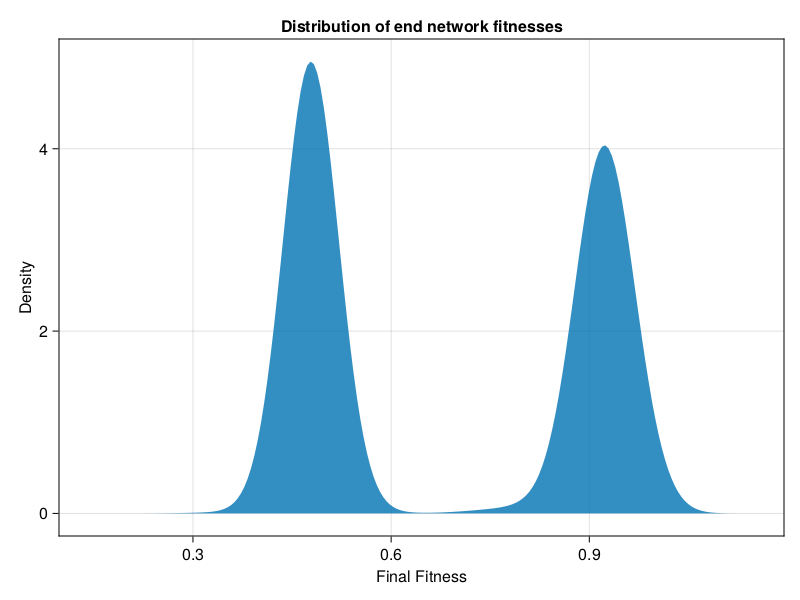

In [8]:
fig = CairoMakie.Figure()
ax = Axis(fig[1,1],xlabel = "Final Fitness",ylabel = "Density", title = "Distribution of end network fitnesses")
CairoMakie.density!(ax,end_fitness)
fig

In [9]:
all_networks = reduce(hcat,map(x->unique(x,dims = 2), gt.geno_traj))

unique_top = unique(sign.(all_networks),dims = 2)

unique_top_map = Dict((i,n) for (n,i) in enumerate(eachcol(unique_top)));

id_to_top_map = Dict((n,i) for (n,i) in enumerate(eachcol(unique_top)));

In [10]:
n_connections_top = [sum(abs.(top)) for top in eachcol(unique_top)]

topology_reorder_complexity = Dict((t,n) for (n,t) in enumerate(sortperm(n_connections_top)));

In [11]:
n_topologies = size(unique_top,2)

429

In [12]:
top_routes = map(traj->mapslices(t->unique_top_map[t],sign.(traj),dims = 1),gt.geno_traj);

In [13]:
all_unique_fitness = unique(reduce(vcat,map(x->unique(x),gt.fitness_traj)))

hist_edges = zeros(11)

hist_edges[1] = gt.initial_fitness

hist_edges[2:10] .= LinRange(gt.initial_fitness+eps(),0.9,9) |> collect

hist_edges[11] = 1.

n_fit_bin = length(hist_edges) - 1

h_fitness = fit(Histogram, all_unique_fitness, hist_edges; closed = :left) 

fitness_routes = map(traj->map(f->StatsBase.binindex(h_fitness, f),traj),gt.fitness_traj);

In [14]:
ft_route = [vcat(reshape(f,(1,length(f))),r) for (f,r) in zip(fitness_routes,top_routes)];

ft_route_tuple = [Tuple.(eachcol(x)) for x in ft_route];

ft_route_rle = map(x->rle(x)[1],ft_route_tuple);

In [377]:
ft_route_tuple 

2500-element Vector{Vector{Tuple{Int64, Int64}}}:
 [(1, 1), (1, 1), (5, 2), (5, 2), (5, 2), (5, 2), (5, 2), (5, 2), (5, 2), (5, 2)  …  (9, 2), (9, 2), (9, 2), (9, 2), (9, 2), (9, 2), (9, 2), (9, 2), (9, 2), (10, 2)]
 [(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)  …  (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (9, 4), (10, 4)]
 [(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)  …  (9, 5), (9, 5), (9, 5), (9, 5), (9, 5), (9, 5), (9, 5), (9, 5), (9, 5), (10, 6)]
 [(1, 1), (4, 1), (5, 2), (5, 2), (5, 2), (5, 2), (5, 2), (5, 2), (5, 2), (5, 2)  …  (9, 5), (9, 5), (9, 5), (9, 5), (9, 5), (9, 5), (9, 5), (9, 5), (9, 5), (10, 5)]
 [(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)  …  (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (8, 8), (10, 9)]
 [(1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (3, 7), (3, 7), (3, 7), (3, 7), (3, 7)  …  (6, 10), (6, 10), (6, 10), (6, 10),

In [16]:
unique_vertices = sort(unique(reduce(vcat,ft_route_rle)));

ft_to_vertex = Dict(i=>n for (n,i) in enumerate(unique_vertices));

vertex_to_ft = Dict(n=>i for (n,i) in enumerate(unique_vertices));

In [17]:
const n_vertices = length(unique_vertices)

1212

In [18]:
start_topology = unique_top_map[sign.(gt.initial_genotype)]

start_vertex = ft_to_vertex[(1,start_topology)]

1

In [19]:
function create_adjacency_matrix(edges)

    adj = zeros(Int64,n_vertices,n_vertices)

    for e in edges
        adj[e...] = 1
    end

    return adj
end

function EvoShell(g,nlist,vertex_to_ft,n_topologies)
    adj_matrix = adjacency_matrix(g)

    (N,j) = size(adj_matrix)

    T = Point{2,Float64}
    locs = Vector{T}(undef, N)

    θ = range(0; stop=2pi, length=n_topologies + 1)[1:(end - 1)]

    radius = 0.0
    if length(nlist[1]) > 1
        radius = 1.0
    end

    for nodes in nlist
        x = T[(radius * cos(θ[vertex_to_ft[n][2]]), radius * sin(θ[vertex_to_ft[n][2]])) for n in nodes]
        locs[nodes] = x
        radius += 1.0
    end
    return locs
end

function EvoShell(g,nlist,vertex_to_ft,topology_reorder,n_topologies)
    adj_matrix = adjacency_matrix(g)

    (N,j) = size(adj_matrix)

    T = Point{2,Float64}
    locs = Vector{T}(undef, N)

    θ = range(0; stop=2pi, length=n_topologies + 1)[1:(end - 1)]

    radius = 0.0
    if length(nlist[1]) > 1
        radius = 1.0
    end

    for nodes in nlist
        x = T[(radius * cos(θ[topology_reorder[vertex_to_ft[n][2]]]), radius * sin(θ[topology_reorder[vertex_to_ft[n][2]]])) for n in nodes]
        locs[nodes] = x
        radius += 1.0
    end
    return locs
end

function outer_ring!(ax,n_connections_top,topology_reorder,n_topologies,color_palette)

    max_radius = 11.

    reverse_map = Dict(angle_n=>top for (top,angle_n) in topology_reorder_complexity)

    T = Point{2,Float64}
    
    θ = range(0; stop=2pi, length=n_topologies + 1)[1:(end - 1)]

    color_id = [let top = reverse_map[n]; (θ,Int(n_connections_top[top])) end for (n,θ) in enumerate(θ)]

    end_theta = []
    end_theta_colors = []   

    for i in 1:length(color_id)-1
        if color_id[i+1][2] > color_id[i][2]
            push!(end_theta,color_id[i][1])
            push!(end_theta_colors,color_id[i][2])
        end
    end

    push!(end_theta,color_id[end][1])
    push!(end_theta_colors,color_id[end][2])

    x = T[(max_radius * cos(θ), max_radius * sin(θ)) for (n,θ) in enumerate(θ)]

    end_x = T[(max_radius * cos(θ), max_radius * sin(θ)) for θ in end_theta]

    # text_x = [max_radius * cos(θ) for θ in end_theta]

    # text_y = [max_radius * sin(θ) for θ in end_theta]

    CairoMakie.lines!(ax,x,color = color_palette[map(x->x[2],color_id)],linewidth = 5.)
    CairoMakie.scatter!(ax,end_x,color = color_palette[end_theta_colors],markersize = 20.)

    offset_θ = [(75 * cos(θ), 75 * sin(θ)) for θ in end_theta]

    # for i in 1:length(end_theta)
    #     CairoMakie.text!(ax,end_x[i],text = string(end_theta_colors[i]) * " connections", align = (:center, :center),offset = offset_θ[i],color = color_palette[end_theta_colors[i]])
    # end

    CairoMakie.text!(ax,end_x,text = string.(end_theta_colors) .* " connections", align = (:center, :center),offset = offset_θ,color = color_palette[end_theta_colors])

    CairoMakie.xlims!(ax,-13,13)
    CairoMakie.ylims!(ax,-13,13)
    
end

outer_ring! (generic function with 1 method)

In [20]:
ft_full_vertex_route = map(traj->map(ft->ft_to_vertex[ft],traj),ft_route_tuple);

ft_vertex_route = map(traj->map(ft->ft_to_vertex[ft],traj),ft_route_rle);

ft_edge_route = map(x->[(x[i],x[i+1]) for i in 1:length(x)-1],ft_vertex_route);

ft_adj_route = map(er->create_adjacency_matrix(er),ft_edge_route);

ft_graph_route = map(ar -> SimpleDiGraph(ar),ft_adj_route);

cyclic_routes = is_cyclic.(ft_graph_route);

In [21]:
ft_edge_route_graph = map(x->[Edge((x[i],x[i+1])) for i in 1:length(x)-1],ft_vertex_route);

In [22]:
order(gex) = [findall(v->vertex_to_ft[v][1] == n,vertices(gex)) for n in 1:n_fit_bin]

order (generic function with 1 method)

In [23]:
gex_all = reduce(union,ft_graph_route);

In [24]:
function create_transition_matrix(edges)

    adj = zeros(Int64,n_vertices,n_vertices)

    vert = 1:n_vertices

    start_counts = zeros(Int64,n_vertices)
    end_counts = zeros(Int64,n_vertices)

    for e in edges
        adj[e...] += 1
        start_counts[e[1]] += 1
        end_counts[e[2]] += 1
    end

    absorbing_states = (end_counts .!= 0) .&& (start_counts .== 0) 

    t_mat = adj ./ [x == 0 ? 1. : x for x in start_counts]

    p_visit = end_counts ./ sum(end_counts)

    for s in vert[absorbing_states]
        t_mat[s,s] = 1.
    end

    return t_mat,p_visit,absorbing_states 
end

tmat,p_visit,absorbing_states = create_transition_matrix(reduce(vcat,ft_edge_route));

sum( 1 .- sum(tmat,dims = 2))

6.661338147750939e-15

In [25]:
# converged = map(x->x[end][1] > 6,ft_route_rle); # beware, histogram edges changes each time

# converged = map(x->x[end][1] > 6,ft_route_rle); # beware, histogram edges changes each time

converged = map(x->x[end] > 0.9,gt.fitness_traj);

In [26]:
vertex_nc = unique(reduce(vcat,ft_vertex_route[.!converged]))
vertex_c = unique(reduce(vcat,ft_vertex_route[converged]));

In [27]:
# P(visit and converge) = P(converge | visit)*P(visit)

prob_visit_vertex(vertex) = sum([vertex ∈ traj for traj in ft_vertex_route])/length(ft_vertex_route)

# prob_visit_vertex(vertex) = vertex == 1 ? 1. : p_visit[vertex]

# prob_converged_given_vertex(vertex) = (sum([vertex ∈ traj for traj in ft_vertex_route[converged]]) / sum([vertex ∈ traj for traj in ft_vertex_route]))

prob_converged_given_vertex(vertex) = (sum([vertex ∈ traj for traj in ft_vertex_route[converged]]) / sum(converged))*(sum(converged)/length(ft_vertex_route))/prob_visit_vertex(vertex)

# prob_traverse_edge(edge) = sum([edge ∈ traj for traj in ft_edge_route_graph])/length(ft_edge_route_graph)

# prob_converged_given_edge(edge) = sum([edge ∈ traj for traj in ft_edge_route_graph[converged]]) / sum([edge∈ traj for traj in ft_edge_route_graph])

prob_edge_and_vertex(edge) = tmat[src(edge),dst(edge)]*prob_visit_vertex(src(edge))

prob_edge_and_vertex (generic function with 1 method)

In [28]:
vertex_prob_exclude_start = [prob_visit_vertex(vertex)  for vertex in 2:length(unique_vertices)];

vertex_prob_converge_exclude_start = [prob_converged_given_vertex(vertex) for vertex in 2:length(unique_vertices)];

# edge_prob_converge_exclude_start = [prob_converged_given_edge(edge) for edge in edges(gex_all)];

edge_prob_exclude_start = [prob_edge_and_vertex(edge) for edge in edges(gex_all)];

In [29]:
converge_prob_color = cgrad([:red, :orange, :green], [0.0, 0.5, 1.])

color_vertex(vertex,scalar) = (converge_prob_color[prob_converged_given_vertex(vertex)],scalar*prob_visit_vertex(vertex))

# color_edge_convergence(edge,scalar) = (converge_prob_color[prob_converged_given_edge(edge)],scalar*prob_edge_and_vertex(edge))

color_edge_traversal(edge,scalar) = (:black,scalar*prob_edge_and_vertex(edge))

color_edge_traversal (generic function with 1 method)

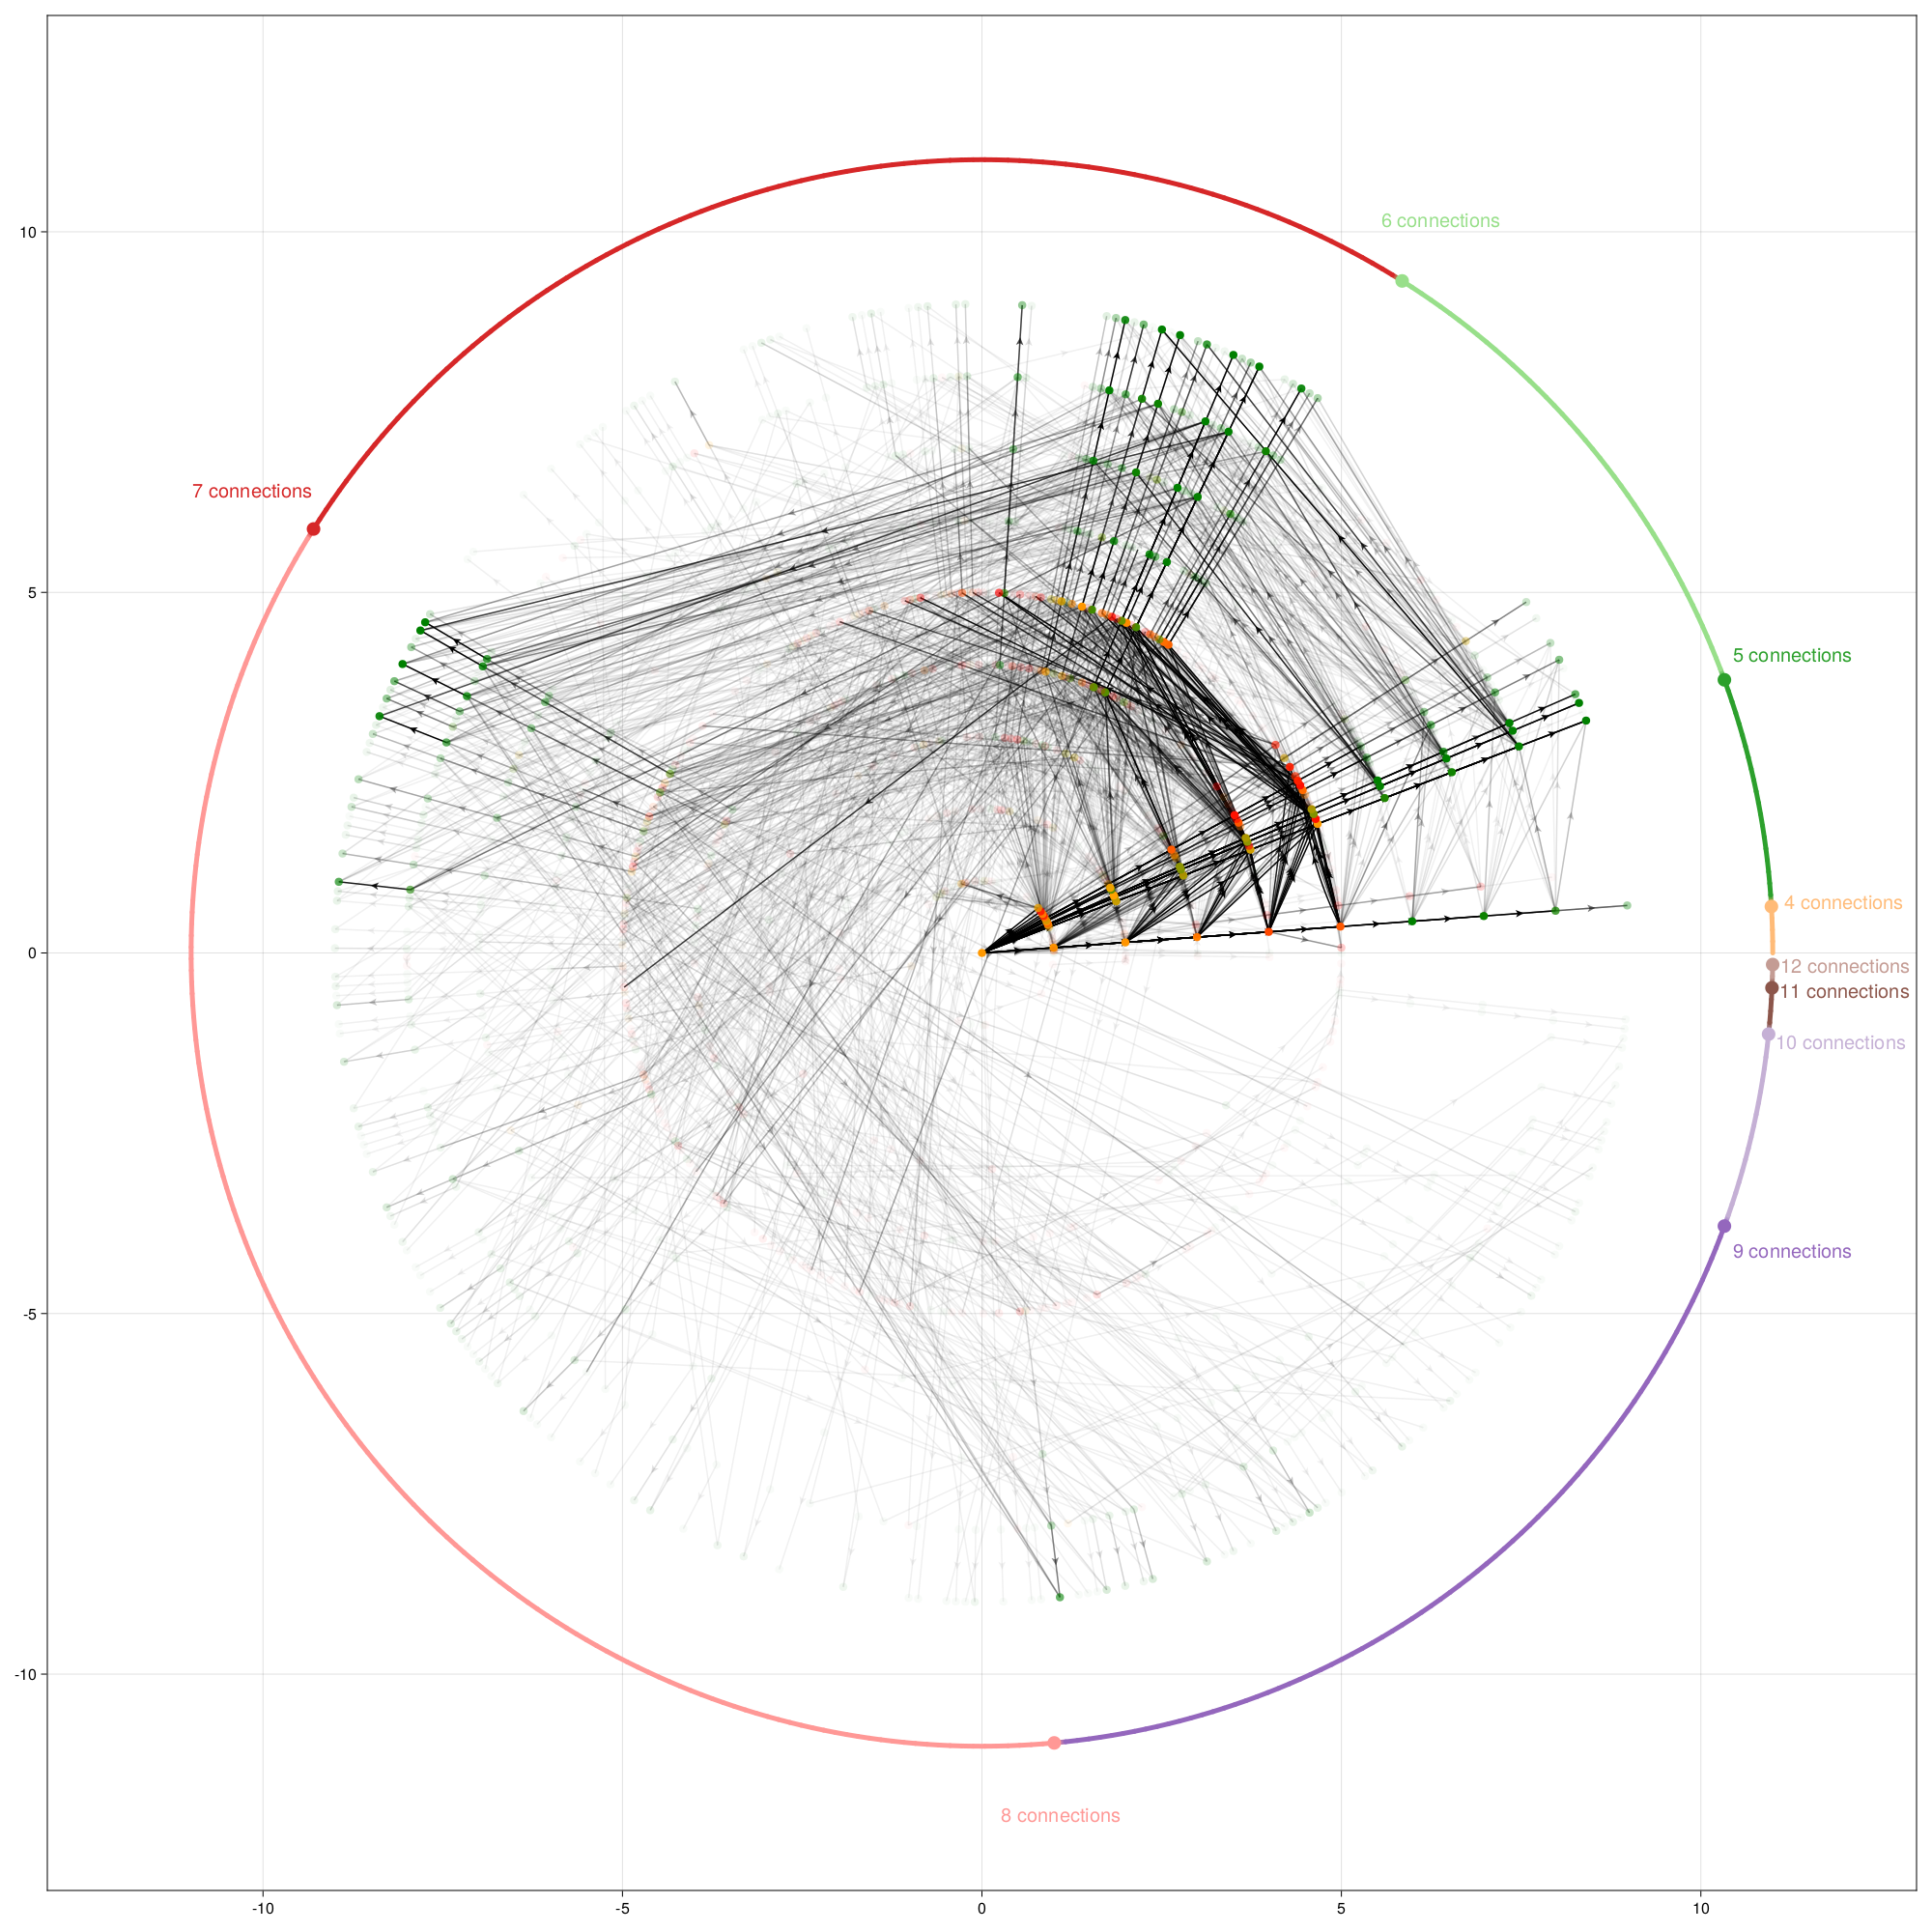

In [30]:
fig = CairoMakie.Figure(resolution = (2000,2000))

ax = Axis(fig[1,1])

layout = Shell(nlist = order(gex_all))

v_color = [color_vertex(v,1/quantile(vertex_prob_exclude_start,0.95)) for v in vertices(gex_all)]

# e_color = [color_edge_convergence(e,1/quantile(edge_prob_exclude_start,0.9)) for e in edges(gex_all)]

e_color = [color_edge_traversal(e,1/quantile(edge_prob_exclude_start,0.95)) for e in edges(gex_all)]

graphplot!(ax,gex_all, layout=x->EvoShell(x,order(gex_all),vertex_to_ft,topology_reorder_complexity,n_topologies),edge_plottype =:beziersegments, node_color = v_color, edge_color = e_color)

outer_ring!(ax,n_connections_top,topology_reorder_complexity,n_topologies,palette(:tab20))

fig

In [413]:
weight_indices = Tuple.(findall(ones(3,4) .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]

function get_edge_weight_mutation_label(edge,vertex_to_ft,id_to_top_map,weight_names)
    source_top = vertex_to_ft[src(edge)][2]
    dest_top = vertex_to_ft[dst(edge)][2]

    if source_top == dest_top 
        return ""
    else
        start_net = id_to_top_map[source_top]
        dest_net = id_to_top_map[dest_top]

        weight_diff = findall(start_net .!= dest_net)

        return weight_names[weight_diff[1]]
    end
end 

function last_network_leaving_vertex(vertex,full_vertex_route,full_geno_traj)

    for v_id in 1:length(full_vertex_route)-1

        vertex_current = full_vertex_route[v_id]
        vertex_next = full_vertex_route[v_id+1]

        if (vertex_current == vertex) && (vertex_next != vertex)
            return reshape(full_geno_traj[:,v_id],(3,4))
        elseif (vertex_current == vertex) && (v_id+1 == length(full_vertex_route))
            return reshape(full_geno_traj[:,v_id],(3,4))
        else
            nothing
        end
    end
end

function first_and_last_networks_vertex(vertex,full_vertex_route,full_geno_traj)

    for v_id in 2:length(full_vertex_route)-1

        vertex_past = full_vertex_route[v_id-1]
        vertex_current = full_vertex_route[v_id]
        vertex_next = full_vertex_route[v_id+1]

        if (vertex_current == vertex) && (vertex_next != vertex)
            return reshape(full_geno_traj[:,v_id],(3,4))
        elseif (vertex_current == vertex) && (v_id+1 == length(full_vertex_route))
            return reshape(full_geno_traj[:,v_id],(3,4))
        else
            nothing
        end
    end
end

function first_and_last_networks_vertex(unique_vertex_route,full_vertex_route,full_geno_traj)

    result = Dict()

    for vertex in unique_vertex_route

        vertex_ids = findall(x->x == vertex,full_vertex_route)

        first_id = minimum(vertex_ids)

        last_id = maximum(vertex_ids)

        result[vertex] = (full_geno_traj[:,first_id],full_geno_traj[:,last_id])
    end

    return result

end

function get_edge_weight_mutation_label(edge,first_last_vertex_dict_1,first_last_vertex_dict_2,ft_graph_route_1,ft_graph_route_2)

    if (edge ∈ edges(ft_graph_route_1)) & (edge ∈ edges(ft_graph_route_2))

        source_last_network_1 = first_last_vertex_dict_1[src(edge)][2]
        dest_first_network_1  = first_last_vertex_dict_1[dst(edge)][1]

        weight_diff_1 = findall(source_last_network_1  .!= dest_first_network_1)

        source_last_network_2 = first_last_vertex_dict_2[src(edge)][2]
        dest_first_network_2  = first_last_vertex_dict_2[dst(edge)][1]

        weight_diff_2 = findall(source_last_network_2  .!= dest_first_network_2)

        return "P: " * weight_names[weight_diff_1[1]] * "C: " * weight_names[weight_diff_2[1]]

    elseif (edge ∈ edges(ft_graph_route_1))

        source_last_network_1 = first_last_vertex_dict_1[src(edge)][2]
        dest_first_network_1  = first_last_vertex_dict_1[dst(edge)][1]

        weight_diff_1 = findall(source_last_network_1  .!= dest_first_network_1)

        return weight_names[weight_diff_1[1]] 
    else

        source_last_network_2 = first_last_vertex_dict_2[src(edge)][2]
        dest_first_network_2  = first_last_vertex_dict_2[dst(edge)][1]

        weight_diff_2 = findall(source_last_network_2  .!= dest_first_network_2)

        return weight_names[weight_diff_2[1]]
    end
end 


    

get_edge_weight_mutation_label (generic function with 2 methods)

In [414]:
first_last_vertex_dict_1 = first_and_last_networks_vertex(ft_vertex_route[choices[1]],ft_full_vertex_route[choices[1]],gt.geno_traj[choices[1]])
first_last_vertex_dict_2 = first_and_last_networks_vertex(ft_vertex_route[choices[2]],ft_full_vertex_route[choices[2]],gt.geno_traj[choices[2]]);

ft_graph_route_1 = ft_graph_route[choices[1]]
ft_graph_route_2 = ft_graph_route[choices[2]]

{1212, 5} directed simple Int64 graph

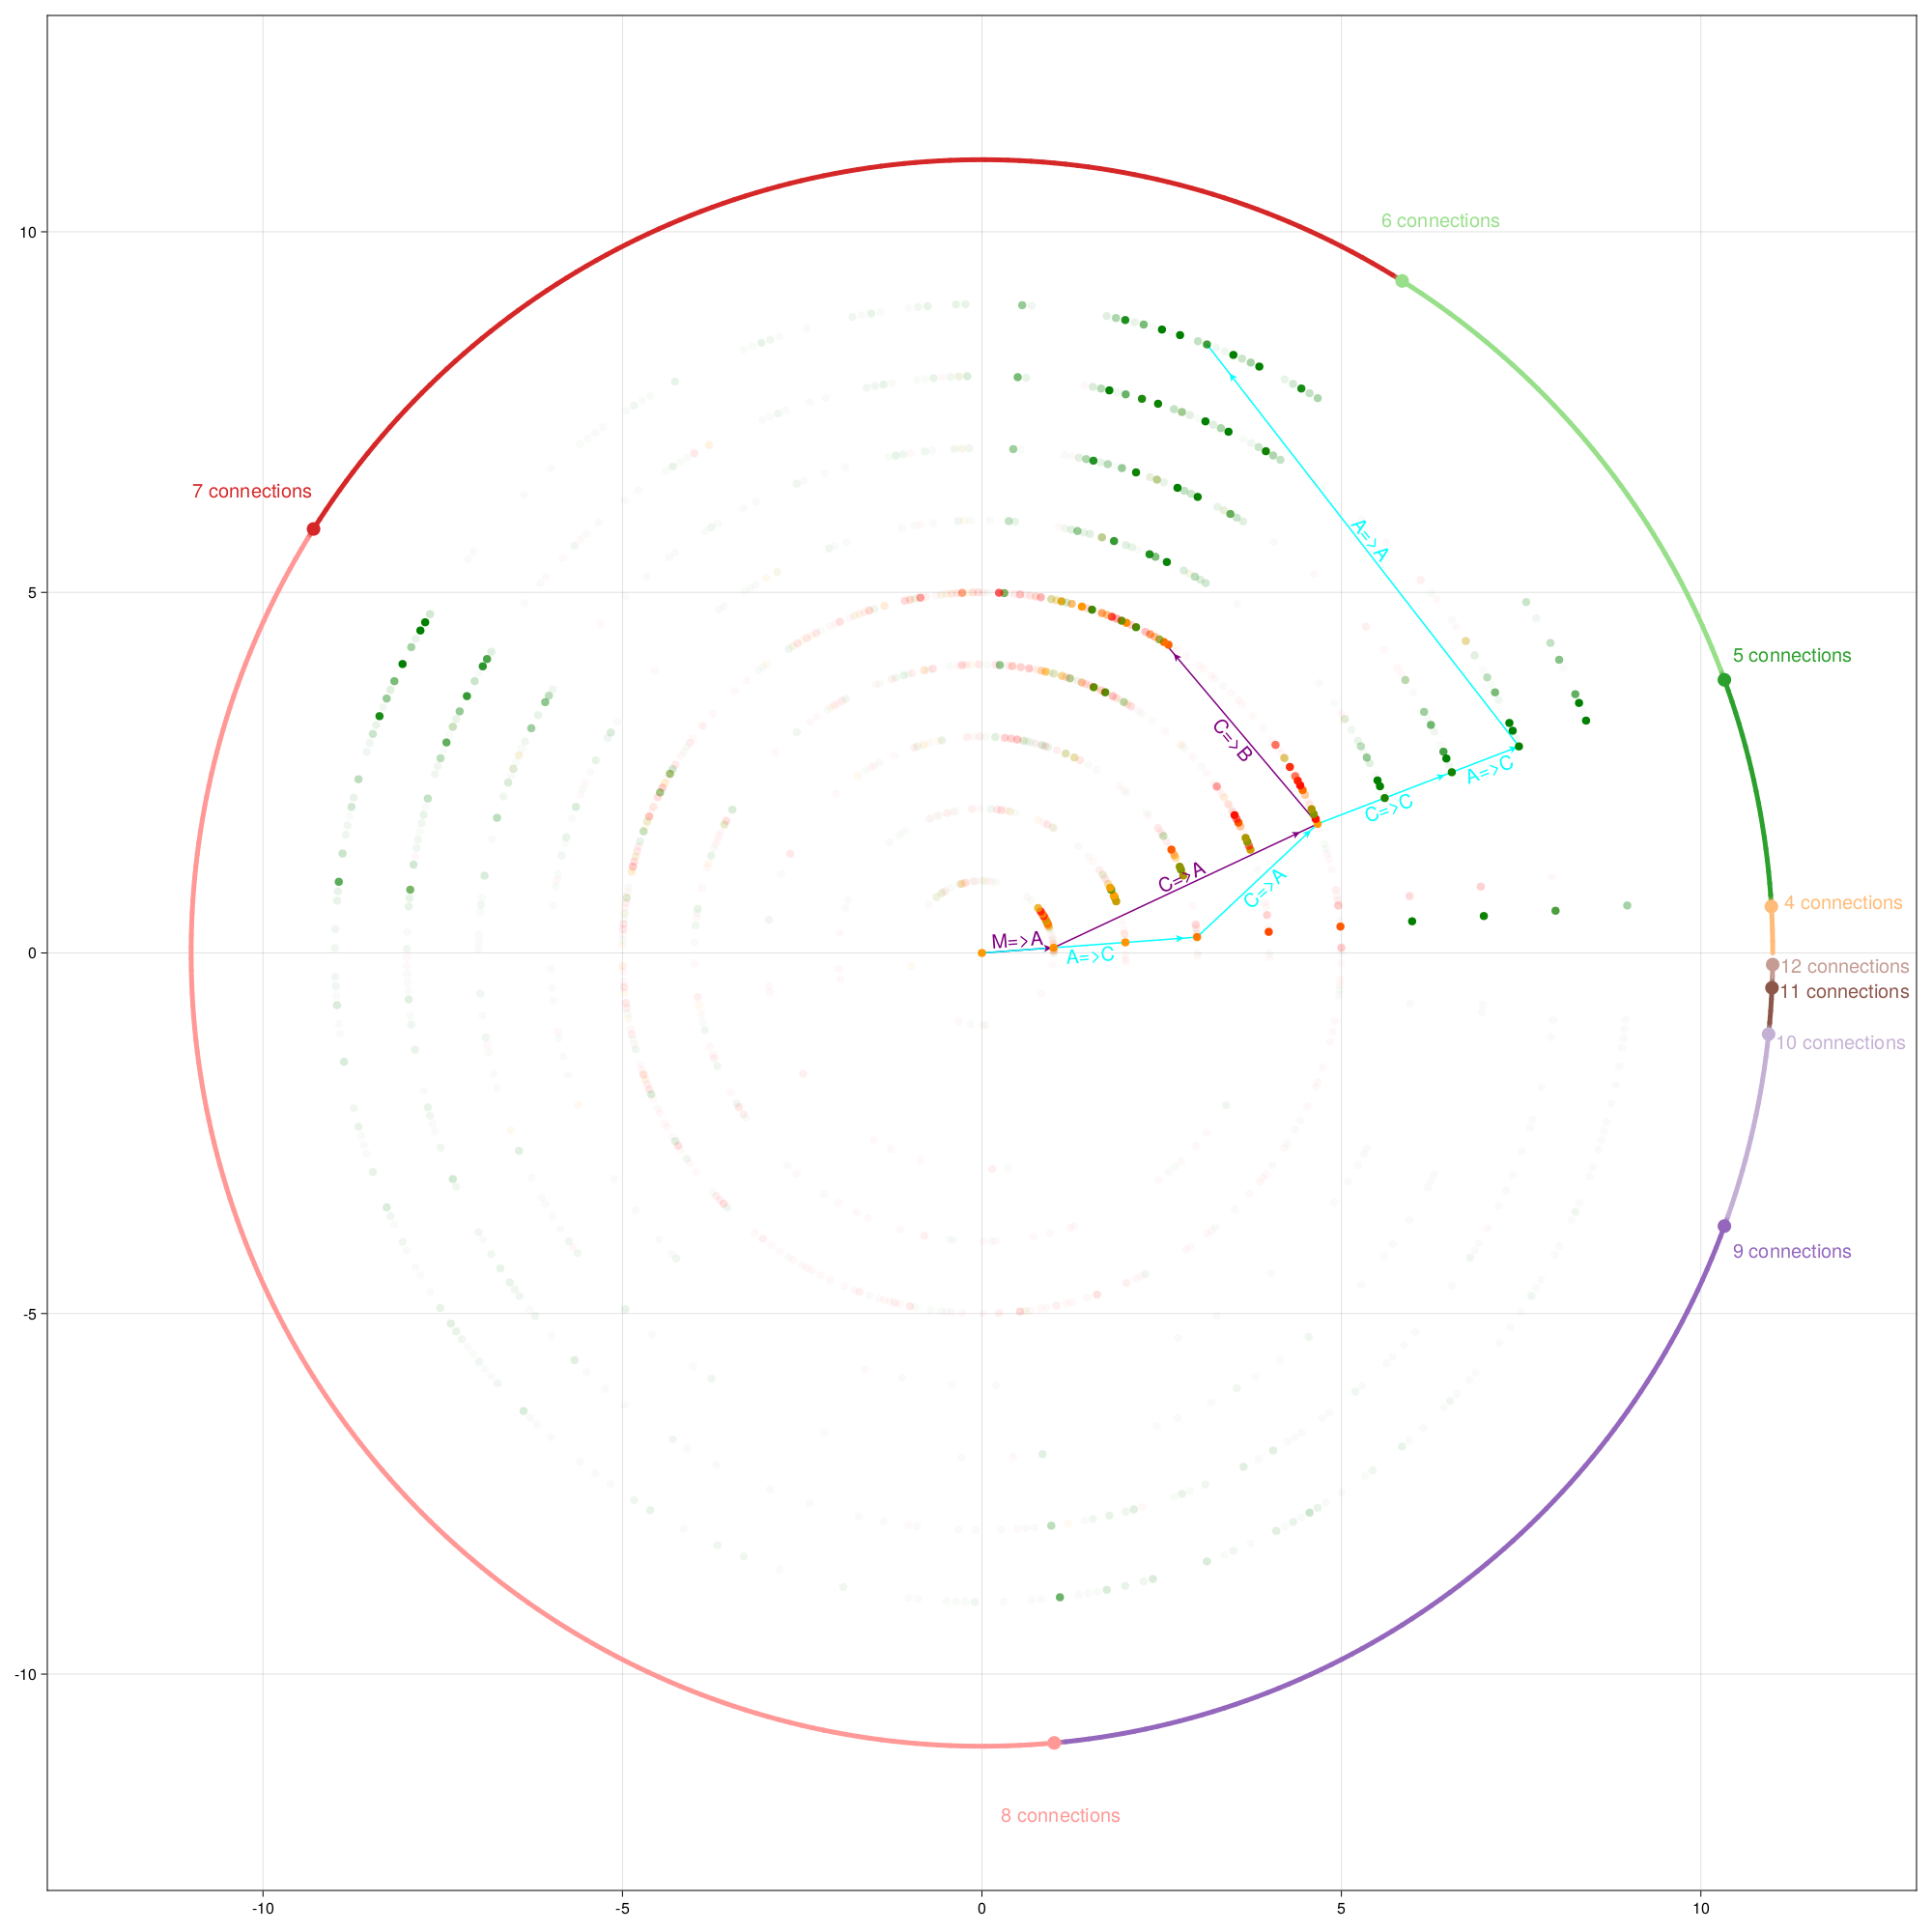

In [415]:
# choices = [1855,1284],[966,355]

# choices = [224,1827] # convergent

choices = [1169, 2182] # divergent

# choices = sample(1:length(ft_graph_route),2,replace = false)

# choices = sample(findall(traj->(6,2) ∈ traj,ft_route_rle),2,replace = false)

gex_subset = reduce(union,ft_graph_route[choices]);

# rem_vertex!(gex_subset,1)

fig = CairoMakie.Figure(resolution = (2000,2000))

ax = Axis(fig[1,1])

layout = Shell(nlist = order(gex_subset))

v_color = [color_vertex(v,1/quantile(vertex_prob_exclude_start,0.95)) for v in vertices(gex_subset)]

# e_color = [color_edge_traversal(e,1/quantile(edge_prob_exclude_start,0.95)) for e in edges(gex_subset)]

e_color = [:black for e in edges(gex_subset)]

e_labels = [get_edge_weight_mutation_label(e,first_last_vertex_dict_1,first_last_vertex_dict_2,ft_graph_route_1,ft_graph_route_2) for e in edges(gex_subset)]

e_labels_side = [(edge ∈ edges(ft_graph_route_1)) ? :left : :right for edge in edges(gex_subset)]

e_color = [(e ∈ edges(ft_graph_route[choices[1]])) & (e ∈ edges(ft_graph_route[choices[2]])) ? :black : (e ∈ edges(ft_graph_route[choices[1]])) ? :purple : :cyan for e in edges(gex_subset)]

graphplot!(ax,gex_subset, layout=x->EvoShell(x,order(gex_all),vertex_to_ft,topology_reorder_complexity,n_topologies),edge_plottype =:beziersegments, node_color = v_color, edge_color = e_color,arrow_shift= 0.92,elabels = e_labels,elabels_color = e_color,elabels_side = e_labels_side)

outer_ring!(ax,n_connections_top,topology_reorder_complexity,n_topologies,palette(:tab20))


fig

In [363]:
ft_route_rle[choices[1]]

4-element Vector{Tuple{Int64, Int64}}:
 (1, 1)
 (2, 1)
 (6, 2)
 (6, 5)

In [364]:
ft_route_rle[choices[2]]

6-element Vector{Tuple{Int64, Int64}}:
 (1, 1)
 (4, 1)
 (6, 2)
 (8, 2)
 (9, 2)
 (10, 30)

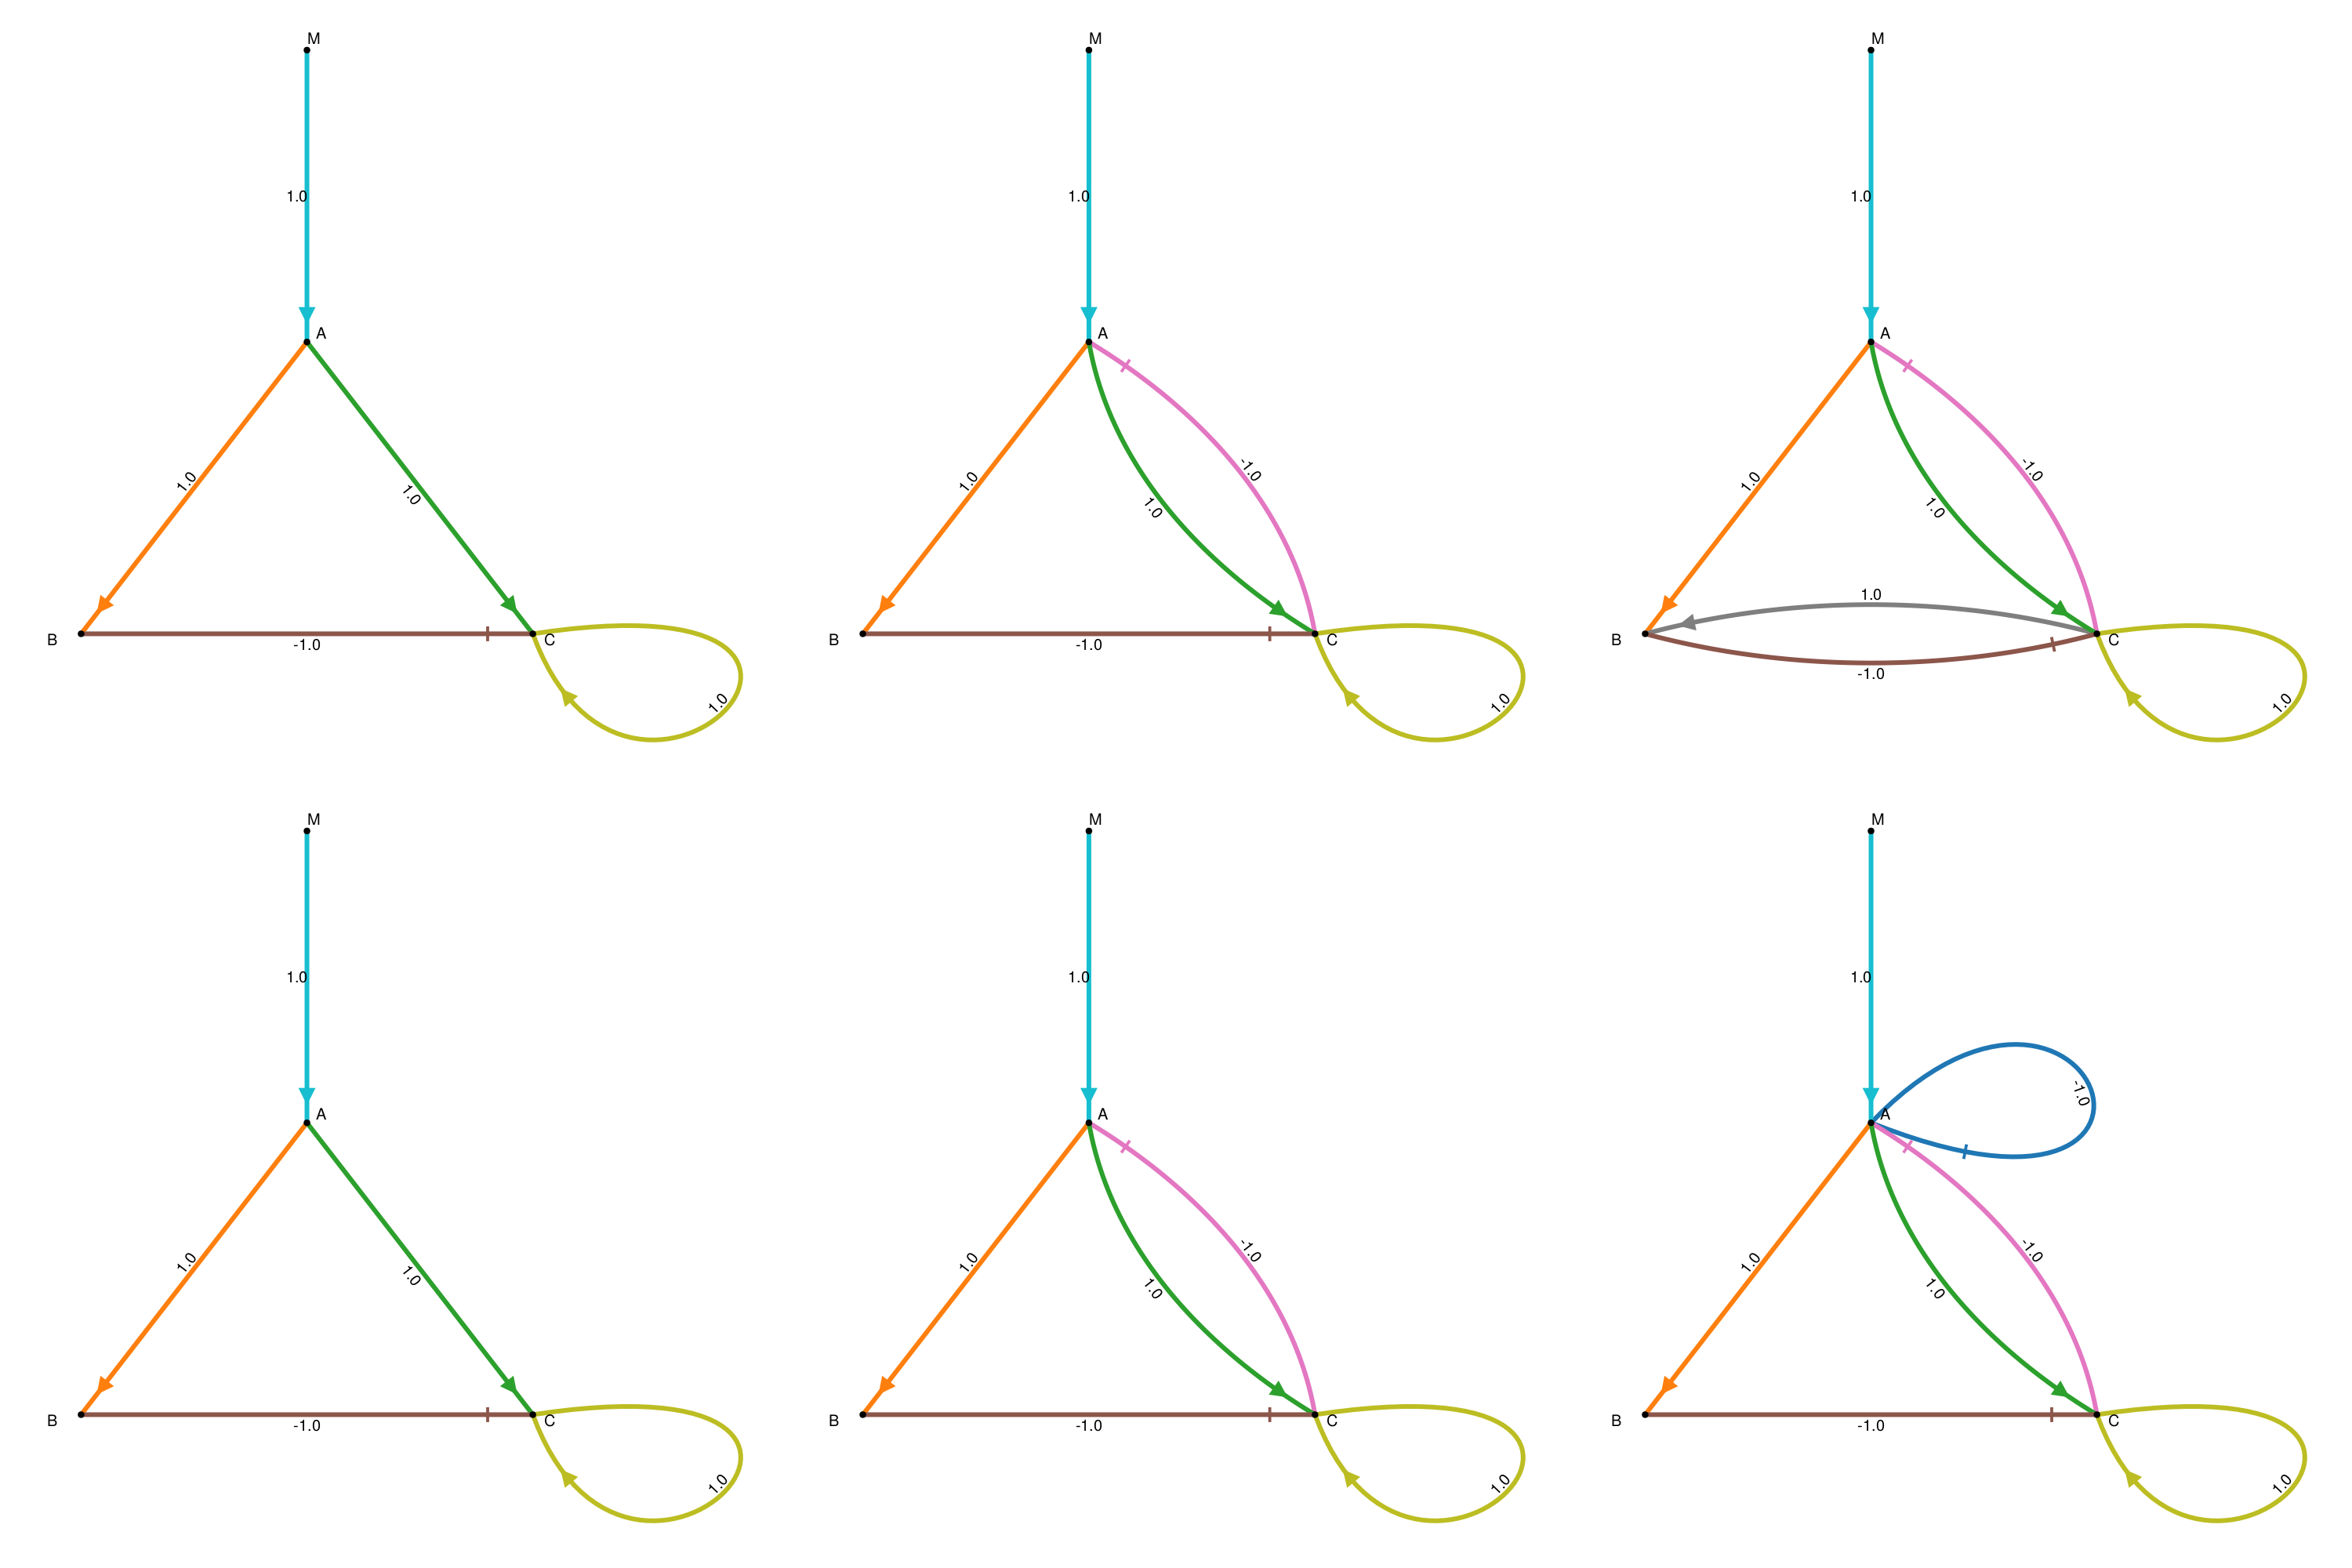

In [417]:
fig = CairoMakie.Figure(resolution = (3000,2000))

for (n,c) in enumerate(choices)

    route_c = unique(map(x->x[2],ft_route_rle[c]))

    # route_c = ft_vertex_route[c]

    # for (fn,t) in route_c
    for (fn,t) in enumerate(route_c)

        ax = Axis(fig[n,fn])

        draw_grn!(ax,reshape(id_to_top_map[t],(3,4)),palette(:tab10))
    end
end

fig

In [269]:
function mutate_method(x,n)

    max_w = 1.
    if x == 0
        proposal = x + n
        r = abs(proposal) > max_w ? max_w*sign(proposal) : proposal
    else
        proposal = x + n*x
        r = abs(proposal) > max_w ? max_w*sign(proposal) : proposal
    end

    return r
end

start_network = [0.0 0.0 0.0 0.28368795845354794; 0.09693796878733349 0.0 0.0 0.0; 0.02660150950444218 -0.26272166357617865 0.6146272196396064 0.0] # right handed

grn_parameters = DefaultGRNParameters();

development = DefaultGRNSolver()

viable_mutations = ones(Int,Ng,Ng+1)

noise_cv = 0.5

mutation_op = MutationOperator(Normal,(μ = 0.0,σ = noise_cv),findall(viable_mutations .> 0))

n_sample_func() = 1

deletion_prob = 0.05

noise_params = (n_sample_func,deletion_prob)

mutate_function = i -> noise(i,mutation_op,noise_params);

noise_application = (x,n) -> mutate_method(x,n)

output_gene = 3

n_target_stripe = 1

fitness_function = s -> fitness_evaluation(s,x->malt_fitness(x,n_target_stripe),output_gene);

In [297]:
function draw_fitness_slices(ll)
    fig = CairoMakie.Figure(resolution = (2000,1800),fontsize = 22.)

    color_scheme = palette(:tab20)

    weight_indices = Tuple.(findall(ones(3,4) .> 0));

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]
        
    ax_list = []

    for wi in 1:length(weight_indices)

        ax1  = Axis(fig[weight_indices[wi]...], backgroundcolor = "white", xlabel="Mutation size", ylabel="Fitness", title = weight_names[wi]) 

        # CairoMakie.scatter!(ax1,phate_pheno_all,markersize = 3.5,color = map(x->x == wi ? color_scheme[wi] : :grey,traj_fm_class_v[choice_full_v]))

        CairoMakie.lines!(ax1,ll.sample_points,ll.slice_fitnesses[weight_indices[wi]...,:],color = color_scheme[wi])

        CairoMakie.scatter!(ax1,[(0.,ll.origin_fitness)],color = color_scheme[wi],markersize = 15.)

        push!(ax_list,ax1)

    end

    linkxaxes!(ax_list...)

    # CairoMakie.lines(ll.sample_points,ll.slice_fitnesses[(1,3)...,:])

    return fig
end

draw_fitness_slices (generic function with 1 method)

In [287]:
function last_network_leaving_topology(ft,ft_route,geno_traj)

    found_id = []

    for n_col in 1:size(ft_route,2)-1

        ft_current = Tuple(ft_route[:,n_col])
        ft_next = Tuple(ft_route[:,n_col+1])

        if (ft_current == ft) && (ft_next != ft)
            push!(found_id,n_col)
            break
        
        elseif (ft_current == ft) && (n_col+1 == size(ft_route,2))
            push!(found_id,n_col)
            break
        end
    end

    return reshape(geno_traj[:,found_id[1]],(3,4))

end

last_network_leaving_topology (generic function with 1 method)

In [422]:
vertices_1 = [ft_to_vertex[(1,1)],ft_to_vertex[(6,2)],ft_to_vertex[(6,5)]]
vertices_2 = [ft_to_vertex[(1,1)],ft_to_vertex[(6,2)],ft_to_vertex[(8,2)]]

3-element Vector{Int64}:
   1
 328
 694

In [426]:
ll_1_list = []

for v in vertices_1
    start_network = reshape(first_last_vertex_dict_1[v][2],(3,4))
    ll = LocalLandscape(start_network,0.95,2000,grn_parameters,development,mutation_op,1.,fitness_function,noise_application);
    push!(ll_1_list,ll)
end

In [428]:
ll_2_list = []

for v in vertices_2
    start_network = reshape(first_last_vertex_dict_2[v][2],(3,4))
    ll = LocalLandscape(start_network,0.95,2000,grn_parameters,development,mutation_op,1.,fitness_function,noise_application);
    push!(ll_2_list,ll)
end

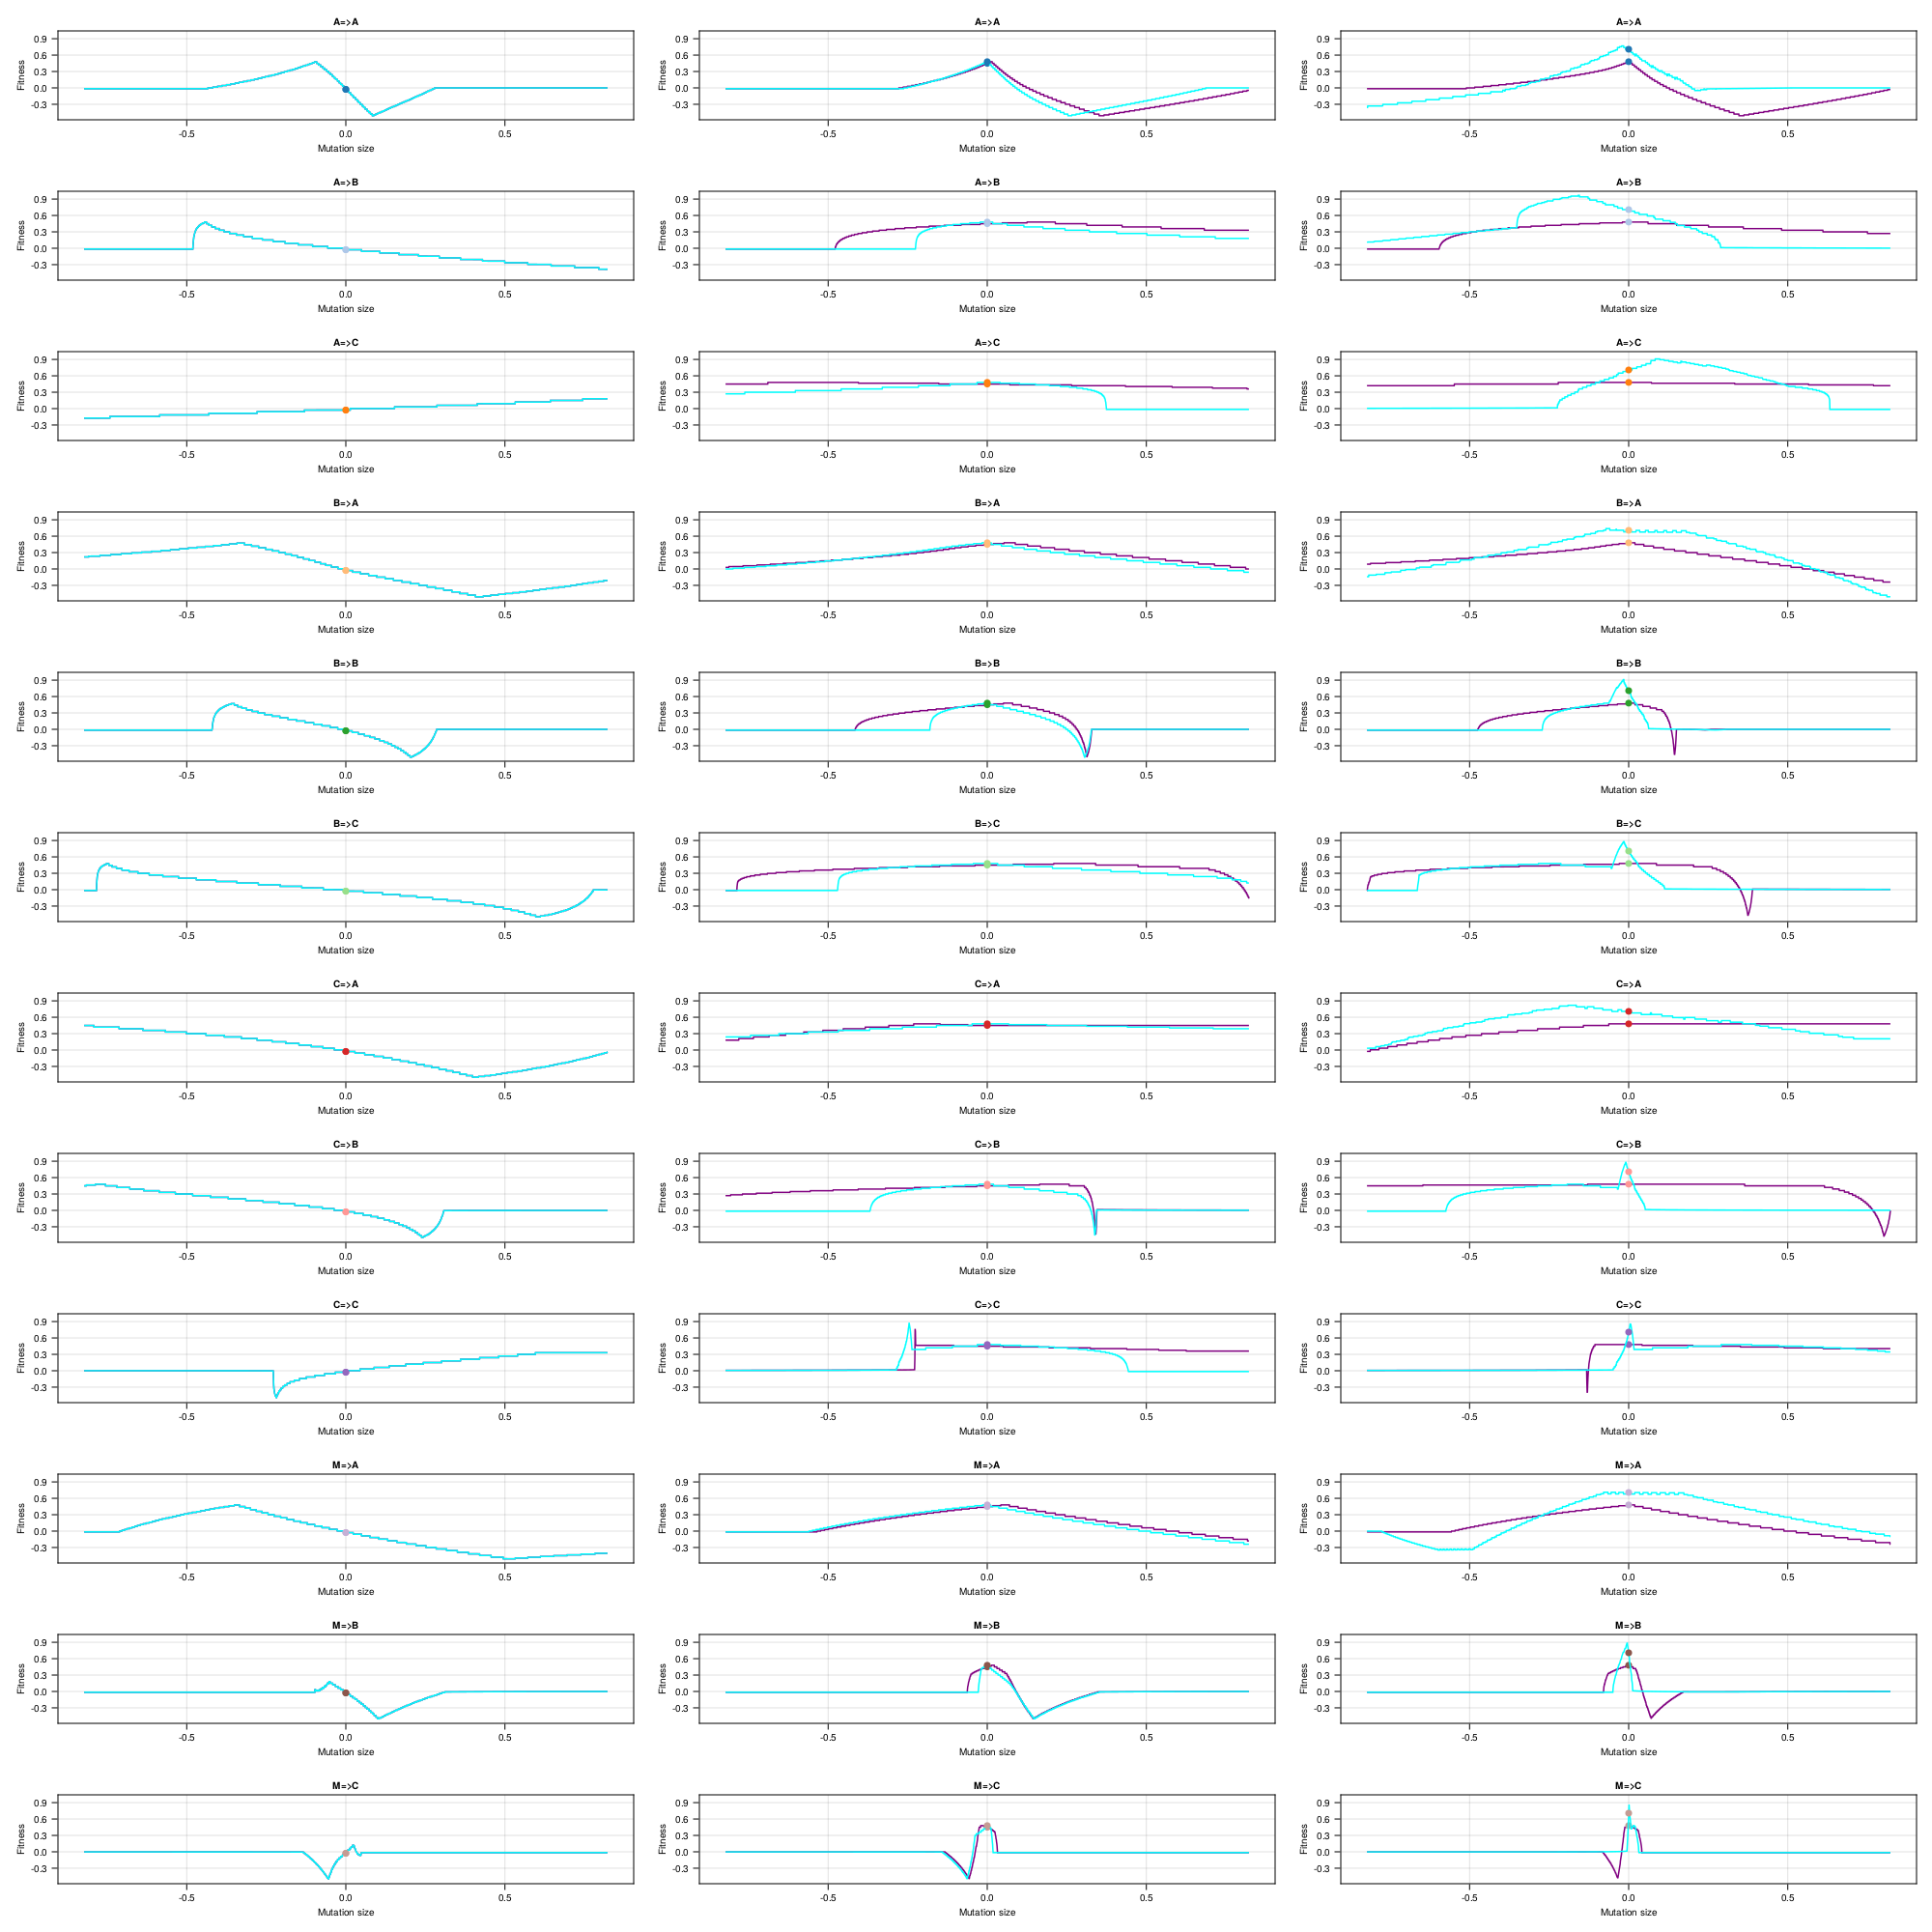

In [431]:
draw_fitness_slices_stack(ll_1_list,ll_2_list)

In [430]:
# c1_network = last_network_leaving_topology((6,2),ft_route[choices[1]],gt.geno_traj[choices[1]])

In [292]:
c2_network = last_network_leaving_topology((6,2),ft_route[choices[2]],gt.geno_traj[choices[2]])

3×4 Matrix{Float64}:
 0.0         0.0       -0.583846  0.283688
 0.096938    0.0        0.0       0.0
 0.0463524  -0.262722   0.614627  0.0

In [294]:
ll_c1 = LocalLandscape(c1_network ,0.95,2000,grn_parameters,development,mutation_op,1.,fitness_function,noise_application);

Calculating Loss Landscape...

In [301]:
ll_c2 = LocalLandscape(c2_network ,0.95,2000,grn_parameters,development,mutation_op,1.,fitness_function,noise_application);

Calculating Loss Landscape...

In [305]:
c1_network_final = last_network_leaving_topology((6,5),ft_route[choices[1]],gt.geno_traj[choices[1]])

3×4 Matrix{Float64}:
 0.0         0.0       -1.0       0.274639
 0.096938    0.0        0.189021  0.0
 0.0266015  -0.262722   0.614627  0.0

In [308]:
c2_network_final = last_network_leaving_topology((8,2),ft_route[choices[2]],gt.geno_traj[choices[2]])

3×4 Matrix{Float64}:
 0.0         0.0       -0.583846  0.283688
 0.096938    0.0        0.0       0.0
 0.0463524  -0.262722   0.461382  0.0

In [307]:
ft_route_rle[choices[2]]

6-element Vector{Tuple{Int64, Int64}}:
 (1, 1)
 (4, 1)
 (6, 2)
 (8, 2)
 (9, 2)
 (10, 30)

In [309]:
ll_c1_final = LocalLandscape(c1_network_final ,0.95,2000,grn_parameters,development,mutation_op,1.,fitness_function,noise_application);

Calculating Loss Landscape...

In [310]:
ll_c2_final = LocalLandscape(c2_network_final ,0.95,2000,grn_parameters,development,mutation_op,1.,fitness_function,noise_application);

Calculating Loss Landscape...

In [370]:
function draw_fitness_slices_stack(ll)
    fig = CairoMakie.Figure(resolution = (200,2000),fontsize = 10.)

    color_scheme = palette(:tab20)

    weight_indices = Tuple.(findall(ones(3,4) .> 0));

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]
        
    ax_list = []

    for wi in 1:length(weight_indices)

        ax1  = Axis(fig[wi,1], backgroundcolor = "white", xlabel="Mutation size", ylabel="Fitness", title = weight_names[wi]) 

        # CairoMakie.scatter!(ax1,phate_pheno_all,markersize = 3.5,color = map(x->x == wi ? color_scheme[wi] : :grey,traj_fm_class_v[choice_full_v]))

        CairoMakie.lines!(ax1,ll.sample_points,ll.slice_fitnesses[weight_indices[wi]...,:],color = color_scheme[wi])

        CairoMakie.scatter!(ax1,[(0.,ll.origin_fitness)],color = color_scheme[wi],markersize = 10.)

        push!(ax_list,ax1)

    end

    linkxaxes!(ax_list...)
    linkyaxes!(ax_list...)

    # CairoMakie.lines(ll.sample_points,ll.slice_fitnesses[(1,3)...,:])

    return fig
end

function draw_fitness_slices_stack(ll_list,ll_labels)
    fig = CairoMakie.Figure(resolution = (200*length(ll_list),2000),fontsize = 10.)

    color_scheme = palette(:tab20)

    weight_indices = Tuple.(findall(ones(3,4) .> 0));

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]

    ax_list = []

    for (n,ll) in enumerate(ll_list)
        
        # ax_list = []

        for wi in 1:length(weight_indices)

            ax1  = Axis(fig[wi,n], backgroundcolor = "white", xlabel="Mutation size", ylabel="Fitness", title = weight_names[wi]) 

            # CairoMakie.scatter!(ax1,phate_pheno_all,markersize = 3.5,color = map(x->x == wi ? color_scheme[wi] : :grey,traj_fm_class_v[choice_full_v]))

            CairoMakie.lines!(ax1,ll.sample_points,ll.slice_fitnesses[weight_indices[wi]...,:],color = color_scheme[wi])

            CairoMakie.scatter!(ax1,[(0.,ll.origin_fitness)],color = color_scheme[wi],markersize = 10.)

            push!(ax_list,ax1)

        end

        # linkxaxes!(ax_list...)
        # linkyaxes!(ax_list...)

    end

    linkxaxes!(ax_list...)
    linkyaxes!(ax_list...)

    # CairoMakie.lines(ll.sample_points,ll.slice_fitnesses[(1,3)...,:])

    return fig
end

function draw_fitness_slices_stack(ll_list_1,ll_list_2)

    fig = CairoMakie.Figure(resolution = (400*length(ll_list_1),2000),fontsize = 10.)

    color_scheme = palette(:tab20)

    weight_indices = Tuple.(findall(ones(3,4) .> 0));

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices]

    ax_list = []

    for (n,ll_tuple) in enumerate(zip(ll_list_1,ll_list_2))
        
        # ax_list = []

        for wi in 1:length(weight_indices)

            ax1  = Axis(fig[wi,n], backgroundcolor = "white", xlabel="Mutation size", ylabel="Fitness", title = weight_names[wi]) 

            # CairoMakie.scatter!(ax1,phate_pheno_all,markersize = 3.5,color = map(x->x == wi ? color_scheme[wi] : :grey,traj_fm_class_v[choice_full_v]))

            CairoMakie.lines!(ax1,ll_tuple[1].sample_points,ll_tuple[1].slice_fitnesses[weight_indices[wi]...,:],color = :purple)

            CairoMakie.scatter!(ax1,[(0.,ll_tuple[1].origin_fitness)],color = color_scheme[wi],markersize = 10.)

            CairoMakie.lines!(ax1,ll_tuple[2].sample_points,ll_tuple[2].slice_fitnesses[weight_indices[wi]...,:],color = :cyan)

            CairoMakie.scatter!(ax1,[(0.,ll_tuple[2].origin_fitness)],color = color_scheme[wi],markersize = 10.)

            push!(ax_list,ax1)

        end

        # linkxaxes!(ax_list...)
        # linkyaxes!(ax_list...)

    end

    linkxaxes!(ax_list...)
    linkyaxes!(ax_list...)

    # CairoMakie.lines(ll.sample_points,ll.slice_fitnesses[(1,3)...,:])

    return fig
end

draw_fitness_slices_stack (generic function with 3 methods)

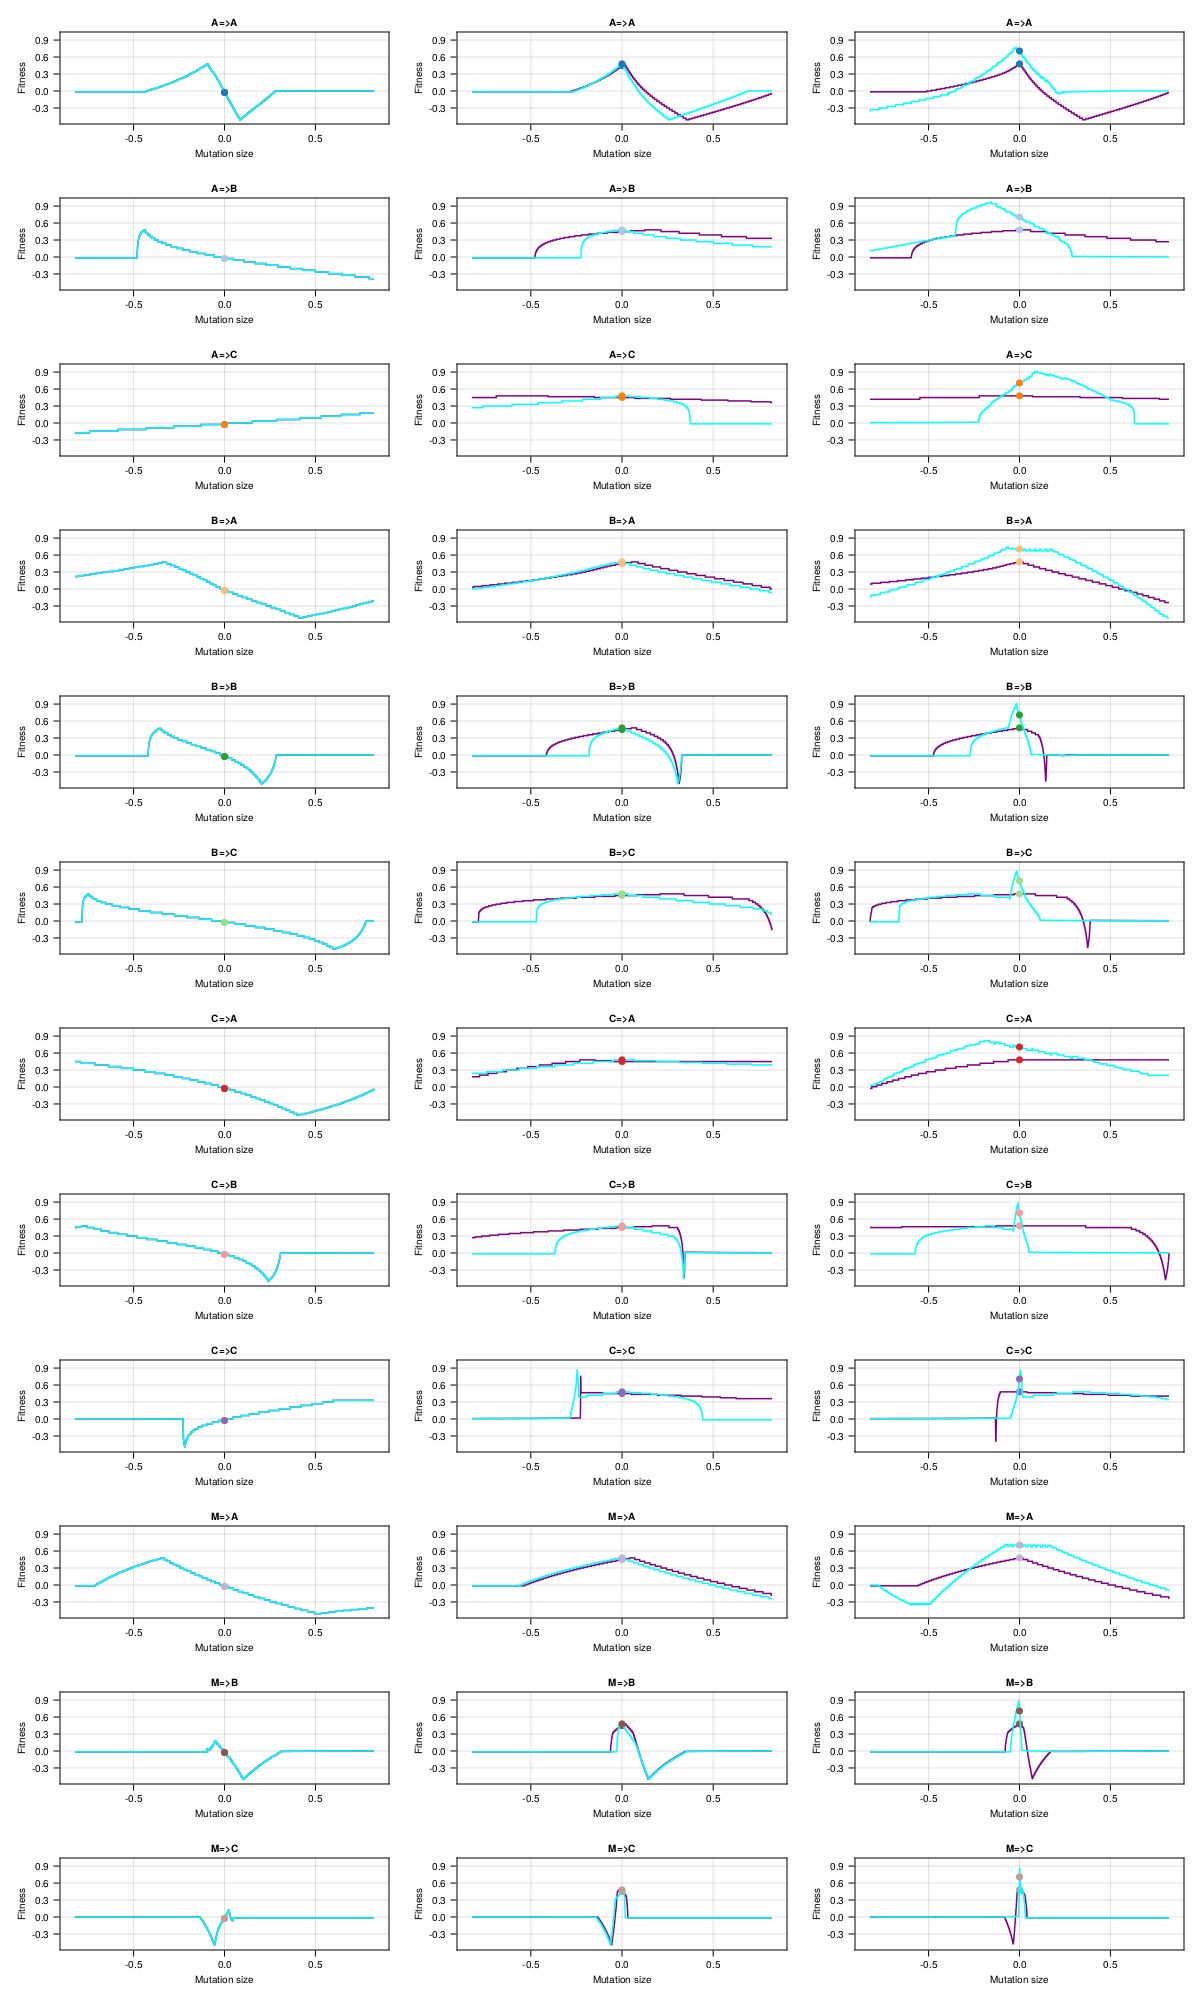

In [371]:
# draw_fitness_slices_stack(ll)

# draw_fitness_slices_stack([ll,ll_c1,ll_c1_final,ll,ll_c2,ll_c2_final],["Start","C1"])

draw_fitness_slices_stack([ll,ll_c1,ll_c1_final],[ll,ll_c2,ll_c2_final])